In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

In [2]:
import diffSPH

In [3]:
from diffSPH.deltaSPH import deltaSPHSimulation
from diffSPH.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

Cuda compiler: /home/winchenbach/anaconda3/envs/torch2


In [4]:
import seaborn as sns
from diffSPH.util import evalArea
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from diffSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from diffSPH.util import scatter_sum
from diffSPH.kernels import *
from diffSPH.randomParticles import generatePeriodicRandomParticles

In [5]:

from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import getKernel


In [6]:
from diffSPH.v2.sampling import sampleRegular
def scatterPlot(fig, axis, pos_x, s, c, cmap = 'viridis', title = None):
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = c.detach().cpu().numpy(), cmap = cmap)

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cb.ax.tick_params(labelsize=8)
    axis.axis('equal')
    axis.set_xlim(minDomain[0], maxDomain[0])
    axis.set_ylim(minDomain[1], maxDomain[1])
    if title is not None:
        axis.set_title(title)

In [7]:
from diffSPH.v2.noise import generateNoise

# One-Dimensional Testing
- non periodic simplex
- non periodic perlin
- periodic simplex
- periodix perlin

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


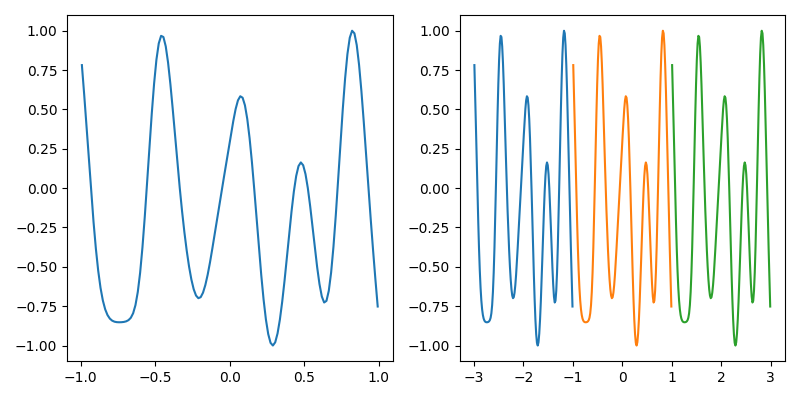

In [8]:
*grid, noise = generateOctaveNoise(n = 128, baseFrequency= 4, dim = 1, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=False, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx = [g.detach().cpu().numpy() for g in grid][0]
axis[0,0].plot(xx, noise.detach().cpu().numpy())
for xoffset in [-1,0,1]:
    axis[0,1].plot(xx + xoffset * 2, noise.detach().cpu().numpy())
fig.tight_layout()

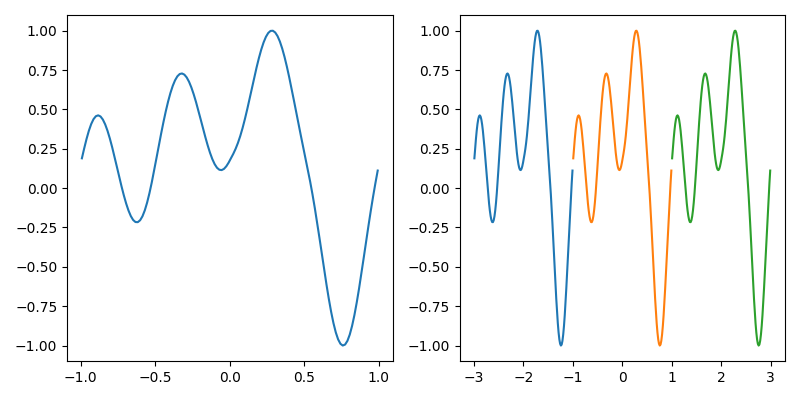

In [9]:
*grid, noise = generateOctaveNoise(n = 128, baseFrequency= 4, dim = 1, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23686, tileable=False, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx = [g.detach().cpu().numpy() for g in grid][0]
axis[0,0].plot(xx, noise.detach().cpu().numpy())
for xoffset in [-1,0,1]:
    axis[0,1].plot(xx + xoffset * 2, noise.detach().cpu().numpy())
fig.tight_layout()

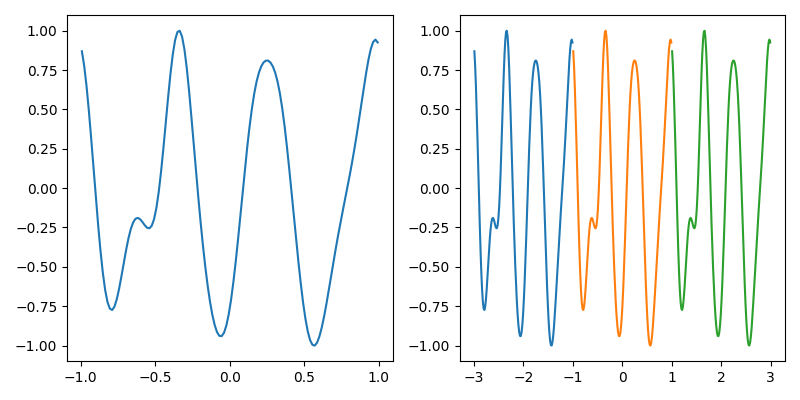

In [10]:
*grid, noise = generateOctaveNoise(n = 128, baseFrequency= 4, dim = 1, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=True, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx = [g.detach().cpu().numpy() for g in grid][0]
axis[0,0].plot(xx, noise.detach().cpu().numpy())
for xoffset in [-1,0,1]:
    axis[0,1].plot(xx + xoffset * 2, noise.detach().cpu().numpy())
fig.tight_layout()

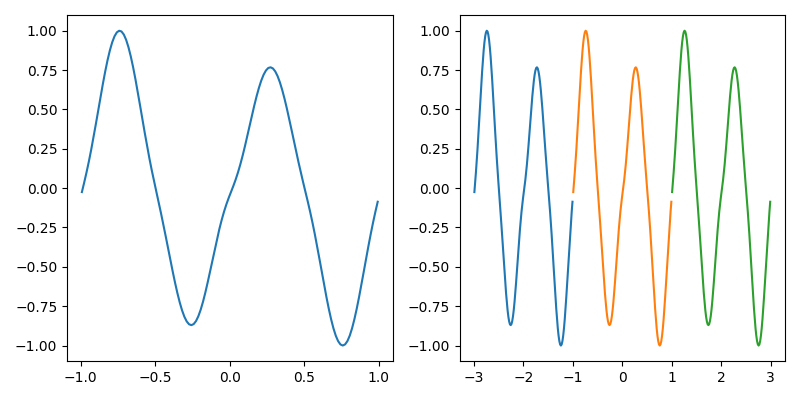

In [11]:
*grid, noise = generateOctaveNoise(n = 128, baseFrequency= 4, dim = 1, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=True, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx = [g.detach().cpu().numpy() for g in grid][0]
axis[0,0].plot(xx, noise.detach().cpu().numpy())
for xoffset in [-1,0,1]:
    axis[0,1].plot(xx + xoffset * 2, noise.detach().cpu().numpy())
fig.tight_layout()

# Two-Dimensional Testing
- non periodic simplex
- non periodic perlin
- periodic simplex
- periodix perlin

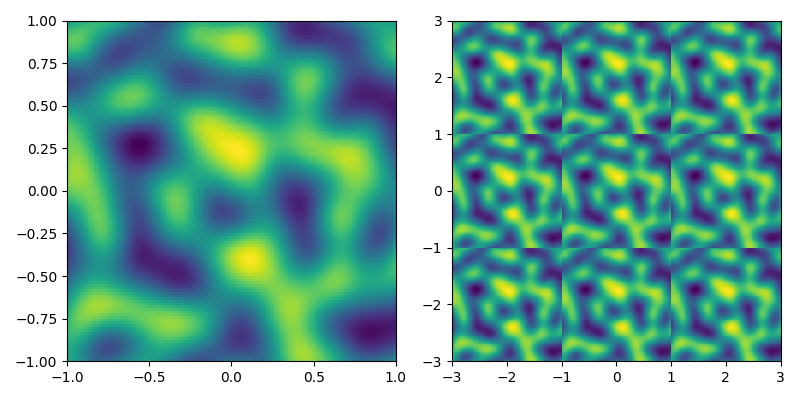

In [12]:
*grid, noise = generateNoise(n = 128, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=False, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noise.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noise.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

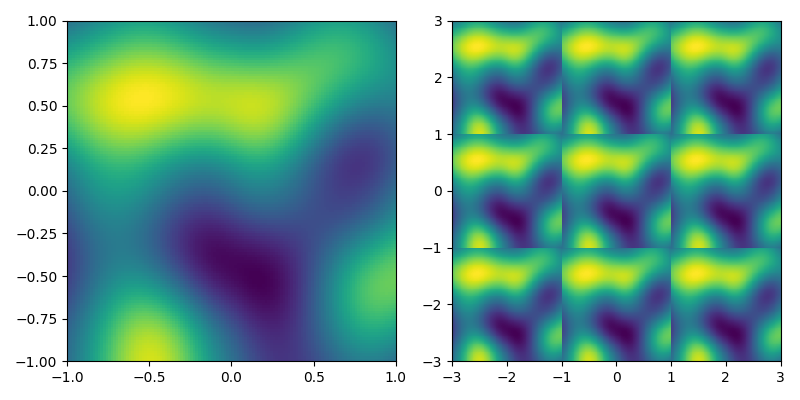

In [13]:
*grid, noise = generateNoise(n = 128, baseFrequency= 2, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=False, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noise.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noise.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

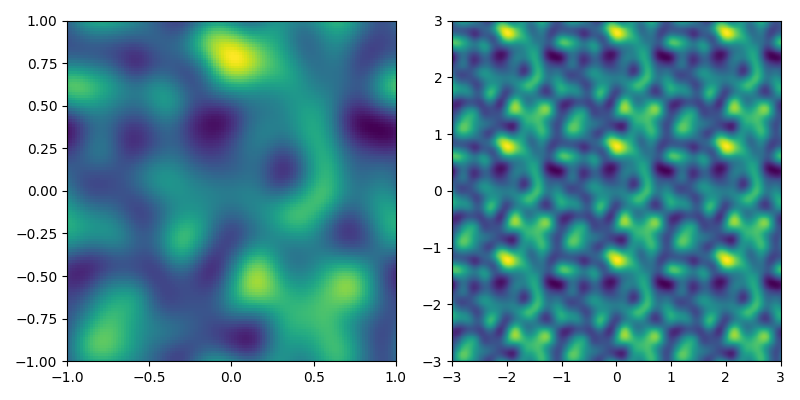

In [33]:
*grid, noiseSimplex = generateNoise(n = 128, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

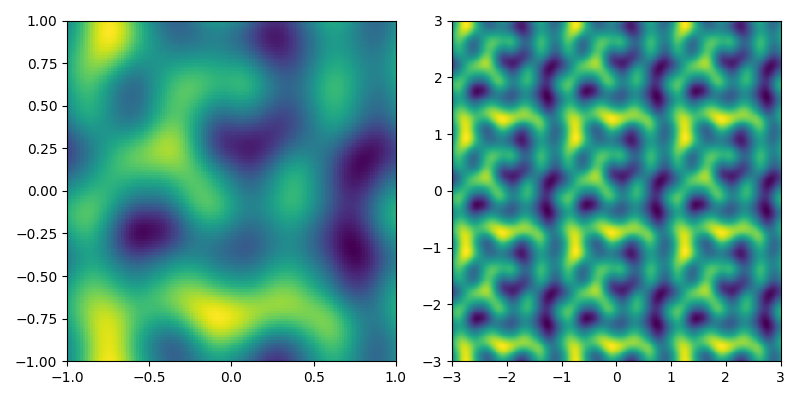

In [34]:
*grid, noisePerlin = generateNoise(n = 128, baseFrequency= 4, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx, yy = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx, yy, noisePerlin.detach().cpu().numpy(), cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noisePerlin.detach().cpu().numpy(), cmap = 'viridis')
fig.tight_layout()

# Two-Dimensional Testing

Visualized is a 2d slice through the origin along the xy plane

- non periodic simplex
- non periodic perlin
- periodic simplex (not implemented)
- periodic perlin 

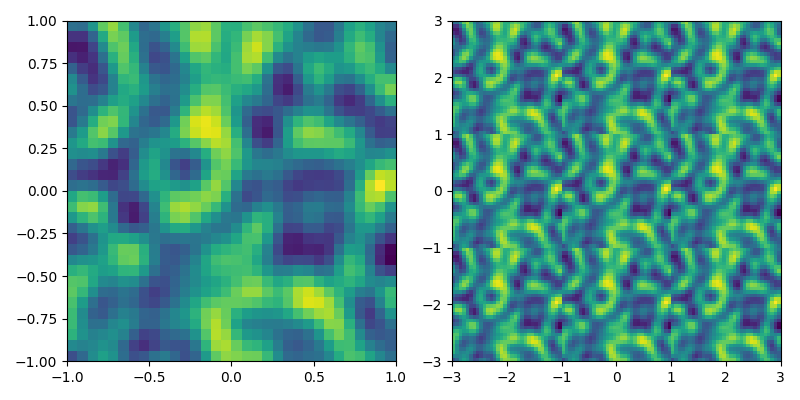

In [16]:
*grid, noise = generateOctaveNoise(n = 32, baseFrequency= 4, dim = 3, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=False, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx,yy,zz = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx[:,:,noise.shape[-1]//2], yy[:,:,noise.shape[-1]//2], noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx[:,:,noise.shape[-1]//2] + xoffset * 2, yy[:,:,noise.shape[-1]//2] + yoffset * 2, noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
fig.tight_layout()

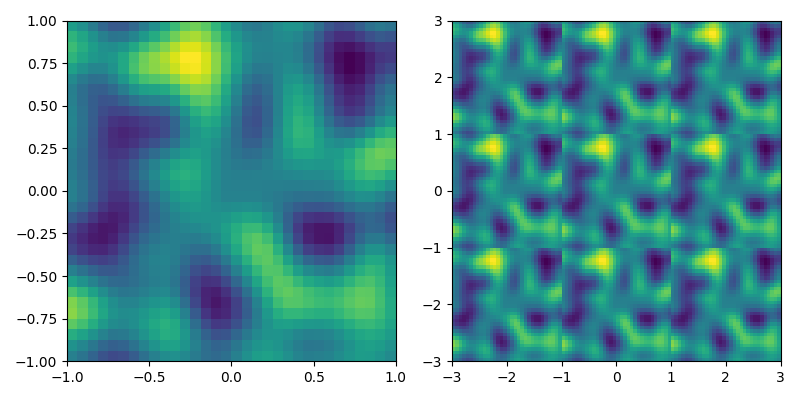

In [17]:
*grid, noise = generateOctaveNoise(n = 32, baseFrequency= 4, dim = 3, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=False, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx,yy,zz = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx[:,:,noise.shape[-1]//2], yy[:,:,noise.shape[-1]//2], noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx[:,:,noise.shape[-1]//2] + xoffset * 2, yy[:,:,noise.shape[-1]//2] + yoffset * 2, noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
fig.tight_layout()

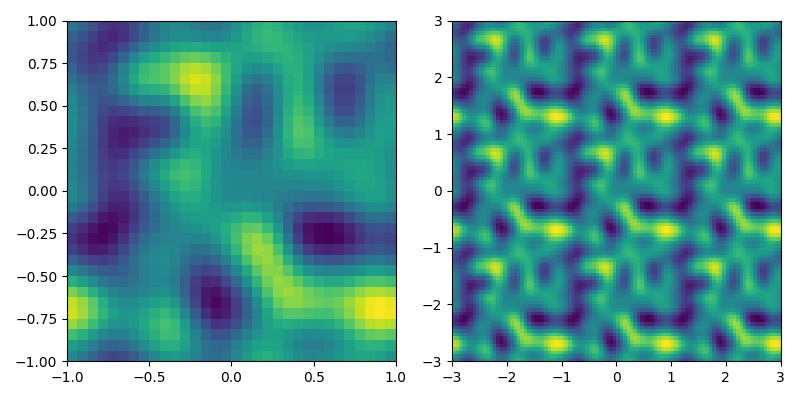

In [18]:
*grid, noise = generateOctaveNoise(n = 32, baseFrequency= 4, dim = 3, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=True, kind = 'perlin')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx,yy,zz = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx[:,:,noise.shape[-1]//2], yy[:,:,noise.shape[-1]//2], noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx[:,:,noise.shape[-1]//2] + xoffset * 2, yy[:,:,noise.shape[-1]//2] + yoffset * 2, noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
fig.tight_layout()

In [19]:
*grid, noise = generateOctaveNoise(n = 32, baseFrequency= 4, dim = 3, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 234686, tileable=True, kind = 'simplex')
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
xx,yy,zz = [g.detach().cpu().numpy() for g in grid]
axis[0,0].pcolormesh(xx[:,:,noise.shape[-1]//2], yy[:,:,noise.shape[-1]//2], noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
for xoffset in [-1,0,1]:
    for yoffset in [-1,0,1]:
        axis[0,1].pcolormesh(xx[:,:,noise.shape[-1]//2] + xoffset * 2, yy[:,:,noise.shape[-1]//2] + yoffset * 2, noise.detach().cpu().numpy()[:,:,noise.shape[-1]//2], cmap = 'viridis')
fig.tight_layout()

Exception: Not implemented yet (noise is not periodic)